In [1]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from parse_filenames import parse_filenames
from scipy import stats
import pickle

In [2]:
path = Path.home() / 'Desktop' / 'disk2' / 'lfp_power_spectra_dump'

In [3]:
parsed_df = parse_filenames(path)
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
0,794812542,VISpm,toWhite,True,2,992.0,sessionID_794812542_area_VISpm_condition_toWhi...
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...
...,...,...,...,...,...,...,...
144,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...
145,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...
146,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...
147,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...


In [4]:
# Deleting rows without 8 conditions

for sid in parsed_df.sessionID.unique():
    if len(parsed_df[parsed_df.sessionID==sid]) != 8:
        parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==sid].index)

In [5]:
conditions = [('VISpm', 'toWhite', True), ('VISpm', 'toBlack', True), ('VISpm', 'toWhite', False), ('VISpm', 'toBlack', False),
             ('VISp', 'toWhite', True), ('VISp', 'toBlack', True), ('VISp', 'toWhite', False), ('VISp', 'toBlack', False)]

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    print(condition, len(selected_df))

('VISpm', 'toWhite', True) 18
('VISpm', 'toBlack', True) 18
('VISpm', 'toWhite', False) 18
('VISpm', 'toBlack', False) 18
('VISp', 'toWhite', True) 18
('VISp', 'toBlack', True) 18
('VISp', 'toWhite', False) 18
('VISp', 'toBlack', False) 18


In [6]:
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...
5,791319847,VISpm,toWhite,True,19,1047.0,sessionID_791319847_area_VISpm_condition_toWhi...
...,...,...,...,...,...,...,...
144,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...
145,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...
146,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...
147,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...


## Session averages

In [11]:
def get_iqr(data):
    iqrs = []

    for t in range(data.shape[1]):
        iqr = stats.iqr(data[:,t])
        iqrs.append(iqr)
        
    return np.array(iqrs)

In [12]:
parsed_df['f'] = ''
parsed_df['before_median'] = ''
parsed_df['before_iqr'] = ''
parsed_df['after_median'] = ''
parsed_df['after_iqr'] = ''

In [13]:
LOAD = True

In [14]:
if LOAD:
    # Load the df
    with open(Path.home() / 'Desktop' / 'disk2' / 'lfp_ps_parsed_df.pkl', 'rb') as f: parsed_df = pickle.load(f)
else:
    for condition in conditions:
        selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
        for cols in selected_df.iterrows():
            f, s1, s2 = np.load(path / cols[1].filename, allow_pickle=True)
            # Saving time data, median time series and iqr (variability measure) time series for eahc condition-session entry
            parsed_df.at[cols[0], 'f'] = f
            parsed_df.at[cols[0], 'before_median'] = np.median(s1, axis=0)
            parsed_df.at[cols[0], 'before_iqr'] = get_iqr(s1)
            parsed_df.at[cols[0], 'after_median'] = np.median(s2, axis=0)
            parsed_df.at[cols[0], 'after_iqr'] = get_iqr(s2)

    # Save the df
    with open(Path.home() / 'Desktop' / 'disk2' / 'lfp_ps_parsed_df.pkl', "wb") as f:
        pickle.dump(parsed_df, f)

In [15]:
parsed_df.head()

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename,f,before_median,before_iqr,after_median,after_iqr
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[9.743131e-11, 4.2587694e-11, 1.0608732e-09, 9...","[8.53174067852458e-11, 3.6044469492457765e-11,...","[7.2236848e-12, 1.3770662e-10, 2.2896499e-10, ...","[6.756960550975688e-12, 3.9087889175393187e-11..."
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[2.171291e-11, 2.903912e-10, 4.77256e-10, 5.28...","[4.783239711432519e-11, 2.216225293560914e-10,...","[3.6862076e-11, 3.7617148e-10, 5.3212945e-10, ...","[7.305404588556219e-11, 2.7185084044978325e-10..."
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.857814e-11, 1.6013009e-10, 1.7074943e-10, 1...","[6.176859978362925e-11, 2.68862647423429e-10, ...","[1.817042e-11, 1.4735858e-10, 1.9964985e-10, 1...","[4.7504630329257835e-11, 1.8354455108560153e-1..."
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[2.7659426e-13, 5.071252e-10, 5.5080973e-10, 5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.3182628e-12, 1.8984227e-10, 2.989714e-10, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,791319847,VISpm,toWhite,True,19,1047.0,sessionID_791319847_area_VISpm_condition_toWhi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[2.616043e-11, 2.6792765e-10, 1.4915114e-10, 9...","[3.812990678406236e-11, 5.103001805839558e-10,...","[2.8520693e-11, 2.1145877e-10, 2.39073e-10, 1....","[5.2051400516173185e-11, 4.945988688054292e-10..."


## Weighted average of power spectra

In [16]:
weighted_average_ps1 = []
weighted_average_ps2 = []

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    N = selected_df.flashesAveragedOver.sum()
    
    collected_weighted_median_ps1 = []
    collected_weighted_iqr_ps1 = []
    collected_weighted_median_ps2 = []
    collected_weighted_iqr_ps2 = []
    
    for cols in selected_df.iterrows():
        f,ps1,ps1_iqr,ps2,ps2_iqr = cols[1]['f'],cols[1]['before_median'],cols[1]['before_iqr'],cols[1]['after_median'],cols[1]['after_iqr']
        
        collected_weighted_median_ps1.append((cols[1].flashesAveragedOver / N) * ps1)
        collected_weighted_iqr_ps1.append((cols[1].flashesAveragedOver / N) * ps1_iqr)
        collected_weighted_median_ps2.append((cols[1].flashesAveragedOver / N) * ps2)
        collected_weighted_iqr_ps2.append((cols[1].flashesAveragedOver / N) * ps2_iqr)
        
    collected_weighted_median_ps1 = np.array(collected_weighted_median_ps1)
    collected_weighted_iqr_ps1 = np.array(collected_weighted_iqr_ps1)
    collected_weighted_median_ps2 = np.array(collected_weighted_median_ps2)
    collected_weighted_iqr_ps2 = np.array(collected_weighted_iqr_ps2)
        
    weighted_average_ps1.append([f, collected_weighted_median_ps1.sum(axis=0), collected_weighted_iqr_ps1.sum(axis=0)]) 
    weighted_average_ps2.append([f, collected_weighted_median_ps2.sum(axis=0), collected_weighted_iqr_ps2.sum(axis=0)])

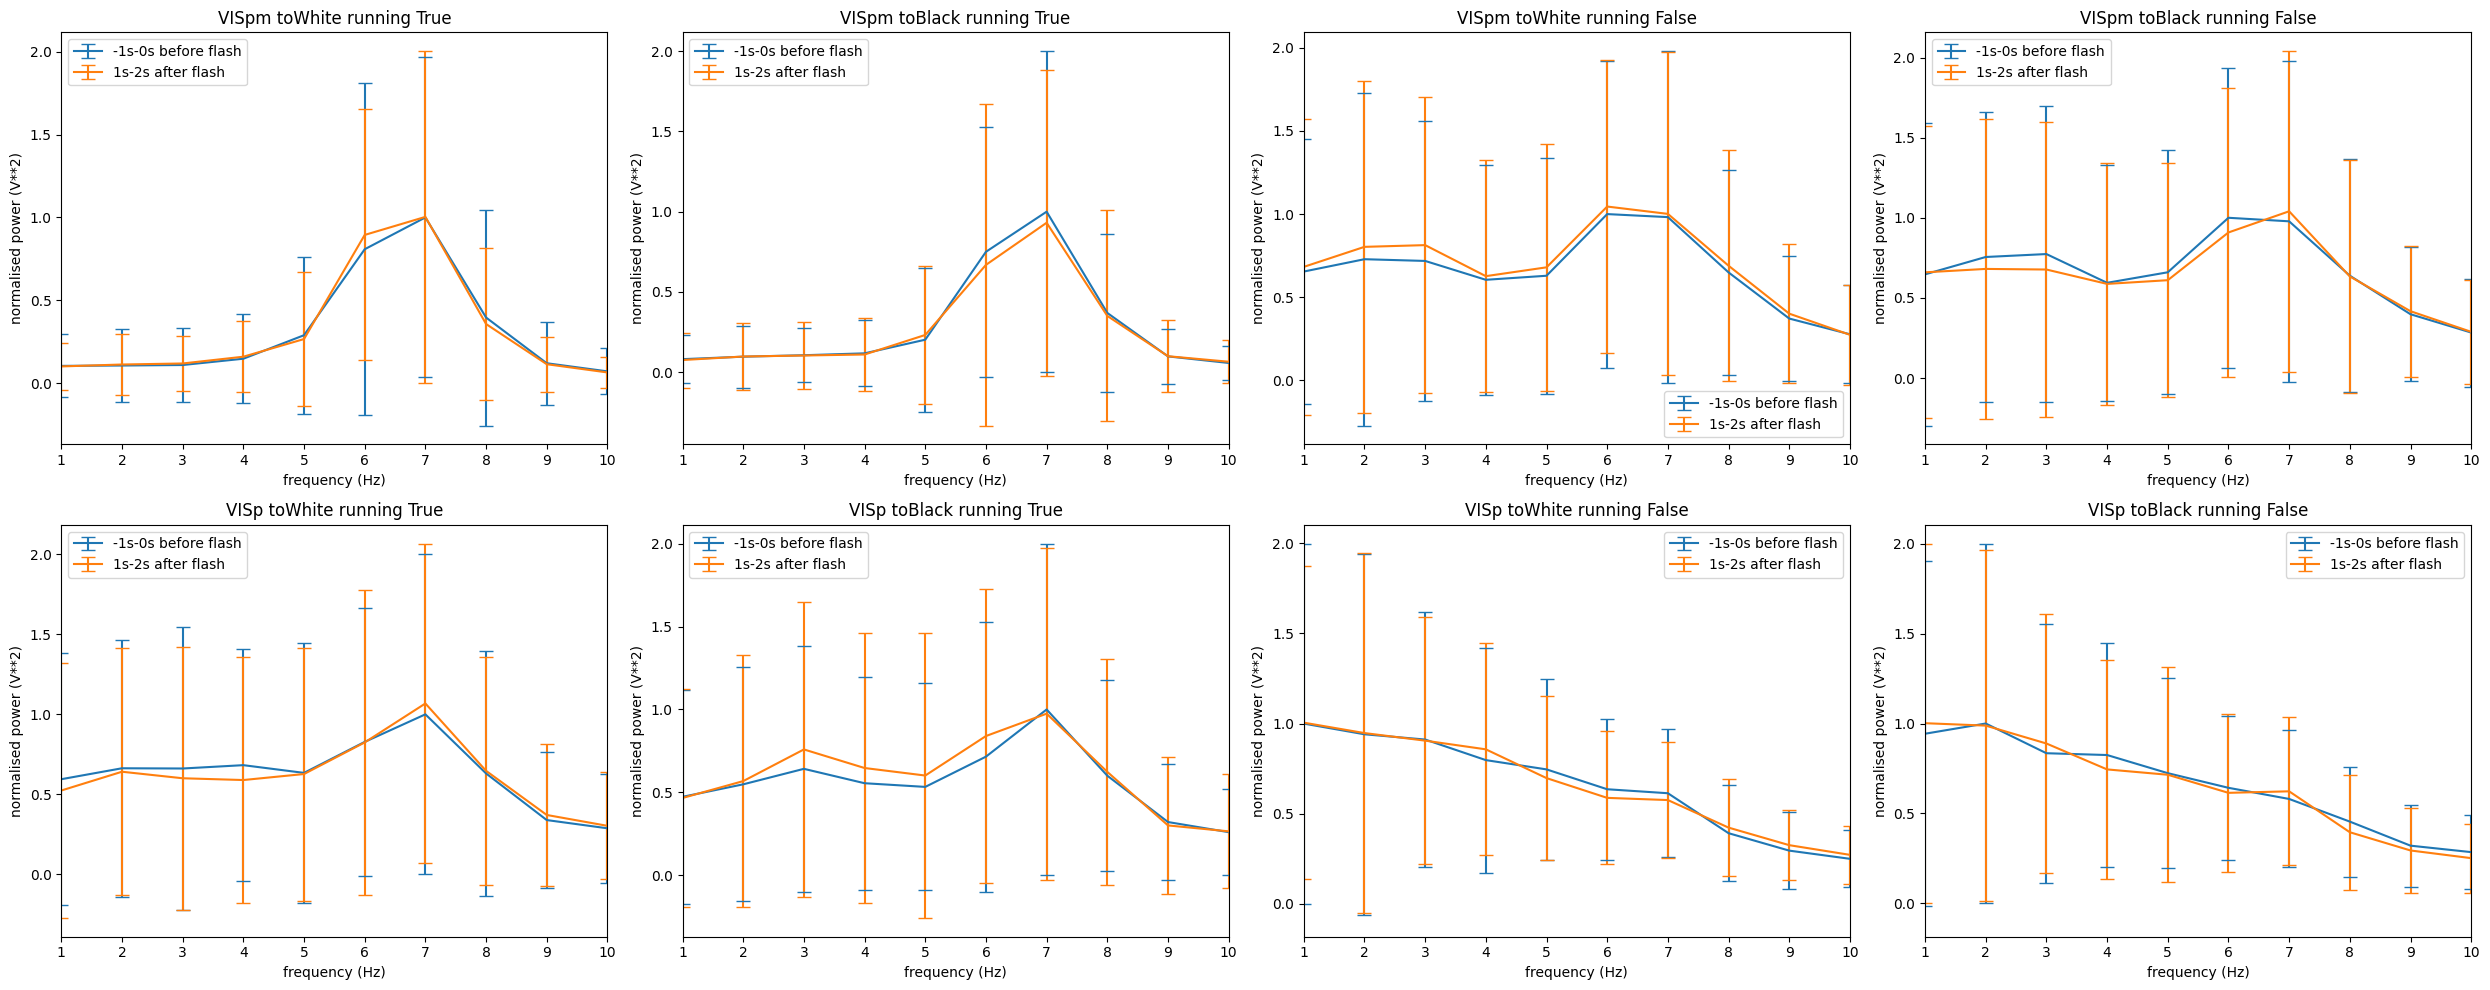

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,10))

for i in range(4):
    # ax[0][i].plot(f,weighted_average_ps1[i][1] / weighted_average_ps1[i][1].max())
    ax[0][i].errorbar(f,weighted_average_ps1[i][1] / weighted_average_ps1[i][1].max(), yerr=weighted_average_ps1[i][2] / weighted_average_ps1[i][2].max(),capsize=5)
    # ax[0][i].plot(f,weighted_average_ps2[i][1] / weighted_average_ps1[i][1].max())
    ax[0][i].errorbar(f,weighted_average_ps2[i][1] / weighted_average_ps1[i][1].max(), yerr=weighted_average_ps2[i][2] / weighted_average_ps2[i][2].max(),capsize=5)
    ax[0][i].set_title(f'{conditions[i][0]} {conditions[i][1]} running {conditions[i][2]}')
    ax[0][i].legend(['-1s-0s before flash','1s-2s after flash'])
    ax[0][i].set_xlabel('frequency (Hz)')
    ax[0][i].set_ylabel('normalised power (V**2)')
    ax[0][i].set_xlim([1,10])
    
for i in range(4):
    # ax[1][i].plot(f,weighted_average_ps1[4+i][1] / weighted_average_ps1[4+i][1].max())
    ax[1][i].errorbar(f,weighted_average_ps1[4+i][1] / weighted_average_ps1[4+i][1].max(), yerr=weighted_average_ps1[4+i][2] / weighted_average_ps1[4+i][2].max(),capsize=5)
    # ax[1][i].plot(f,weighted_average_ps2[4+i][1] / weighted_average_ps1[4+i][1].max())
    ax[1][i].errorbar(f,weighted_average_ps2[4+i][1] / weighted_average_ps1[4+i][1].max(), yerr=weighted_average_ps2[4+i][2] / weighted_average_ps2[4+i][2].max(),capsize=5)
    ax[1][i].set_title(f'{conditions[4+i][0]} {conditions[4+i][1]} running {conditions[4+i][2]}')
    ax[1][i].legend(['-1s-0s before flash','1s-2s after flash'])
    ax[1][i].set_xlabel('frequency (Hz)')
    ax[1][i].set_ylabel('normalised power (V**2)')
    ax[1][i].set_xlim([1,10])
    
plt.tight_layout()

plt.savefig('grand_average_lfp_power_spectra.png')

plt.show()